# Semantic Segmentation using Encoder and Decoder

In [29]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import imageio # for reading and writing the image data o

import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout 
from keras.layers import Conv2DTranspose, concatenate

In [30]:

path = ''
image_path = os.path.join(path, './data/CameraRGB/')
mask_path = os.path.join(path, './data/CameraMask/')

# os.listdir() list all the files in the dir
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)

# make path to each of the image in the dir
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

In [31]:
len(image_list), len(mask_list)

(1060, 1060)

/tmp/ipykernel_102281/1809428382.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_list[N])
/tmp/ipykernel_102281/1809428382.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_list[N])


Text(0.5, 1.0, 'Segmented Image')

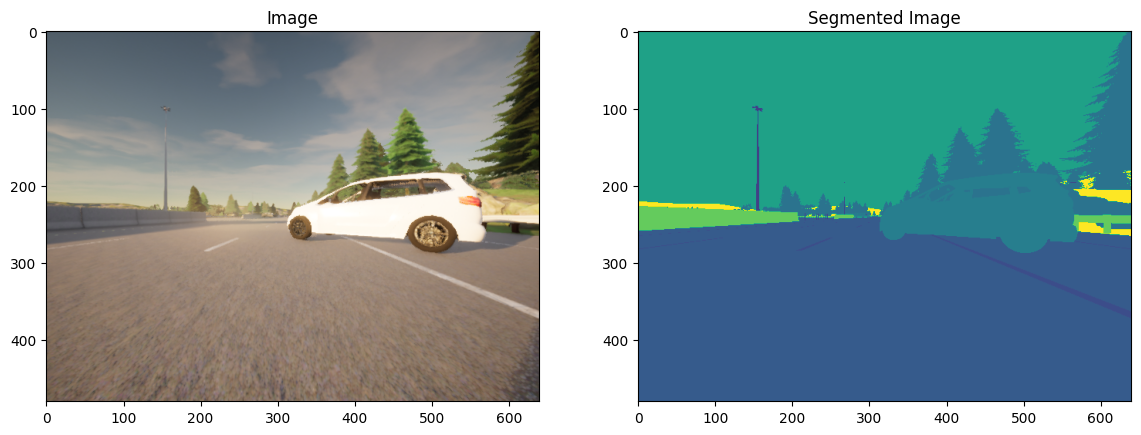

In [32]:
N = 3

img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])

fig, arr = plt.subplots(1, 2, figsize = (14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')

arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmented Image')

In [33]:
# creates a tensorflow dataset, tf.data.Dataset.list_files()

image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

# zipping both the dataset
for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraRGB/000026.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraMask/000026.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraRGB/000027.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraMask/000027.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraRGB/000028.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraMask/000028.png'>)


In [34]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

# creating a dataset from a pair of tensors
dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))
# represents the image file paths and maks files paths in aa Tuple in Tensor

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'./data/CameraRGB/014390.png', shape=(), dtype=string)
tf.Tensor(b'./data/CameraMask/014390.png', shape=(), dtype=string)


## Preprocess the Dataset

In [35]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

In [36]:

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    input_image = input_image / 255.

    return input_image, input_mask

In [37]:
# map() is a tensorflow function used to apply a function to each element of the dataset
# a element has both image and mask. 
image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)


# U-Net

Primarily used for tumour detection, for also other semantic segmentation tasks

Encoder - Downsampling steps

Decoder - Upsampling steps


## Conv_block

In [38]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    conv = Conv2D(filters=n_filters,
                  kernel_size=3,
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal') (inputs)
    
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    
    if dropout_prob > 0:
        conv = Dropout(rate=dropout_prob)(conv)
    
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=2, strides=2)(conv)
    else:
        next_layer = conv # input for the next layer
    
    skip_connection = conv
    
    # in U-Net, last layer is the skip connection
    return next_layer, skip_connection
# next layer and skip connection output


In [39]:
input_size=(96, 128, 3)
n_filters = 32
inputs = Input(input_size)
cblock1 = conv_block(inputs, n_filters * 1)
model1 = tf.keras.Model(inputs=inputs, outputs=cblock1)

output1 = [['InputLayer', [(None, 96, 128, 3)], 0],
            ['Conv2D', (None, 96, 128, 32), 896, 'same', 'relu', 'HeNormal'],
            ['Conv2D', (None, 96, 128, 32), 9248, 'same', 'relu', 'HeNormal'],
            ['MaxPooling2D', (None, 48, 64, 32), 0, (2, 2)]]



## Decoder (Unsampling Block)

In [40]:
def unsampling_block(expansive_input, contractive_input, n_filters=32):
    '''
    expansive_input - Input tensor from prev layer
    contractive_input - Input tensor from previous skip layer
    '''
    
    up = Conv2DTranspose(filters=n_filters, #no of filters
                         kernel_size=2,
                         strides=2,
                         padding='same')(expansive_input)
    
    #merge the previous output and the contractive input
    merge = concatenate(inputs=[up, contractive_input], axis=3)
    
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge)
    
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    
    return conv

In [41]:
input_size1=(12, 16, 256)
input_size2 = (24, 32, 128)
n_filters = 32

expansive_inputs = Input(input_size1)
contractive_inputs = Input(input_size2)

cblock1 = unsampling_block(expansive_inputs, contractive_inputs, n_filters)

model1 = tf.keras.Model(inputs=[expansive_inputs, contractive_inputs], outputs=cblock1)


# U-Net Model

In [42]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    inputs = Input(input_size)
    
    # Downsampling box - Encoder
    # conv -> pooling
    cblock1 = conv_block(inputs, n_filters*1)
    cblock2 = conv_block(cblock1[0], n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters*8, dropout_prob=0.3)
    # with max_pooling, conv_block -> hidden_conv
    cblock5 = conv_block(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False)
    
    # Upsample box - Decode
    ublock6 = unsampling_block(cblock5[0], cblock4[1], n_filters*8)
        
    ublock7 = unsampling_block(ublock6, cblock3[1], n_filters*4)
    ublock8 = unsampling_block(ublock7, cblock2[1], n_filters*2)
    ublock9 = unsampling_block(ublock8, cblock1[1], n_filters*1)
    
    conv9 = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(ublock9)
    
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    
    model = tf.keras.Model(inputs = inputs, outputs = conv10)
    
    return model

### Model Dimension

In [43]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

In [44]:
unet.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 96, 128, 3)]         0         []                            
                                                                                                  
 conv2d_68 (Conv2D)          (None, 96, 128, 32)          896       ['input_10[0][0]']            
                                                                                                  
 conv2d_69 (Conv2D)          (None, 96, 128, 32)          9248      ['conv2d_68[0][0]']           
                                                                                                  
 max_pooling2d_14 (MaxPooli  (None, 48, 64, 32)           0         ['conv2d_69[0][0]']           
 ng2D)                                                                                      

In [45]:
len(unet.layers)

35

#### Loss Function

In [46]:
unet.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

## Data Processing

In [47]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(480, 640, 1)


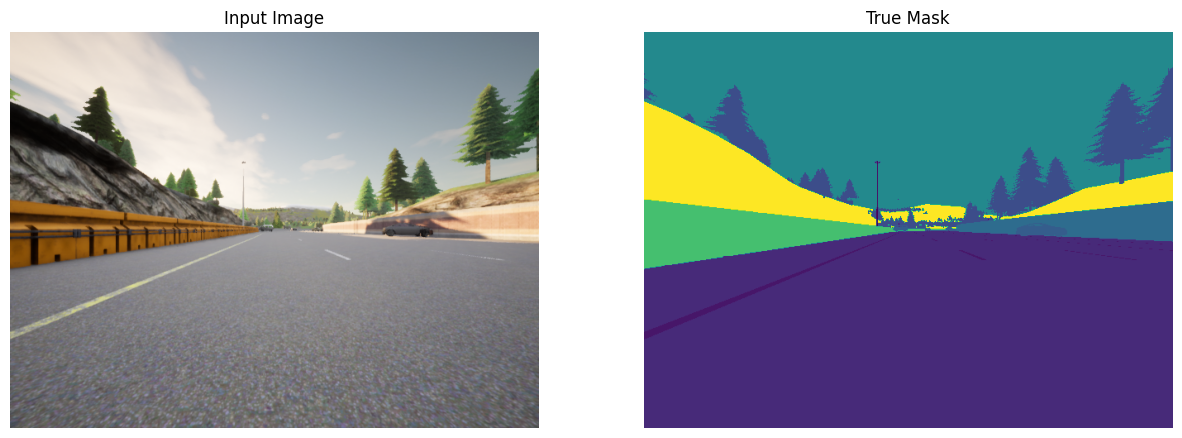

In [48]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
    
display([sample_image, sample_mask])

## Train the model

In [49]:
EPOCHS = 40
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32

processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/40


2023-08-26 15:20:53.282581: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


34/34 [==============================] - 132s 4s/step - loss: 2.6180 - accuracy: 0.3786
Epoch 2/40
34/34 [==============================] - 114s 3s/step - loss: 1.5354 - accuracy: 0.4662
Epoch 3/40
34/34 [==============================] - 74s 2s/step - loss: 0.9316 - accuracy: 0.7559
Epoch 4/40
34/34 [==============================] - 59s 2s/step - loss: 0.7852 - accuracy: 0.7701
Epoch 5/40
34/34 [==============================] - 59s 2s/step - loss: 0.7565 - accuracy: 0.7736
Epoch 6/40
34/34 [==============================] - 59s 2s/step - loss: 0.7181 - accuracy: 0.7777
Epoch 7/40
34/34 [==============================] - 60s 2s/step - loss: 0.7011 - accuracy: 0.7808
Epoch 8/40
34/34 [==============================] - 58s 2s/step - loss: 0.6494 - accuracy: 0.7924
Epoch 9/40
34/34 [==============================] - 60s 2s/step - loss: 0.6102 - accuracy: 0.8015
Epoch 10/40
34/34 [==============================] - 65s 2s/step - loss: 0.5771 - accuracy: 0.8115
Epoch 11/40
34/34 [=========

## Save the model

In [56]:
import os

PATH = os.path

model_save_path = 'UNet_model.h5'

unet.save(model_save_path)

print(model_save_path)
print("SAVED!!")

UNet_model.h5
SAVED!!


/home/jerlshin/env_ai/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [57]:
## Load the model
unet = tf.keras.models.load_model(model_save_path)

## Create a Predicted Masks

In [58]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [ ]:
plt.plot(model_history.history["accuracy"])
plt.title("Accuracy")

In [60]:
## Showing the Predictions

In [61]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
show_predictions(train_dataset, 2)